<a href="https://colab.research.google.com/github/deguc/datascience/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

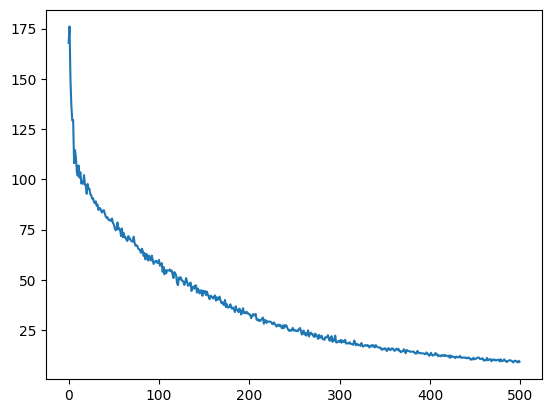

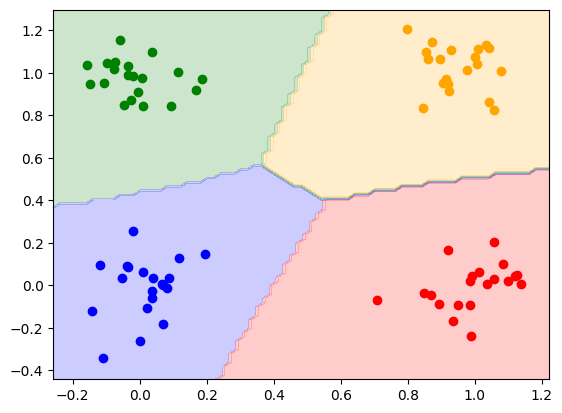

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


#マルチレイヤーネットワーク

def MakeData(y=[0,1,1,1],N=50,loc=0,scale=0.05):

  #N=10         データのサイズ
  #loc          平均
  #scale=0.05   標準偏差

  X_=np.array([[0,0],[0,1],[1,0],[1,1]])#学習用データ

  #元のデータにノイズを足す。
  X0=X_[0]+np.random.normal(size=(N,2),loc=loc,scale=scale)
  X1=X_[1]+np.random.normal(size=(N,2),loc=loc,scale=scale)
  X2=X_[2]+np.random.normal(size=(N,2),loc=loc,scale=scale)
  X3=X_[3]+np.random.normal(size=(N,2),loc=loc,scale=scale)
  X=np.concatenate((X0,X1,X2,X3))   #データを結合する。

  #正解ラベル
  y0=np.full(N,y[0])
  y1=np.full(N,y[1])
  y2=np.full(N,y[2])
  y3=np.full(N,y[3])
  y=np.concatenate((y0,y1,y2,y3))   #データを結合する

  return X,y

def plot(X,y,c=['red','blue','green','orange']):
  #データをプロットする。
  n=y.max()
  for k in range(n+1):
    plt.scatter(X[y==k,0],X[y==k,1],c=c[k]);

def decision_regions(x,y,model,resolution=0.02):

  #平面を分割する。

  #カラーマップの準備
  colors=['red','blue','green','orange']
  cmap=ListedColormap(colors[:len(np.unique(y))])

  #グリッドの作成
  mg=0.1 #マージン
  x1_min,x1_max=X[:,0].min()-mg,x[:,0].max()+mg
  x2_min,x2_max=X[:,1].min()-mg,x[:,1].max()+mg
  x1=np.arange(x1_min,x1_max,resolution)   #横軸
  x2=np.arange(x2_min,x2_max,resolution)   #縦軸
  xx1,xx2=np.meshgrid(x1,x2)    #メッシュ
  z=np.array([xx1.ravel(),xx2.ravel()]).T   #座標点の作成

  Z=model.predict(z).reshape(xx1.shape)   #各座標点を分類する

  plot(x,y,c=colors) #データをプロットする。

  plt.contourf(xx1,xx2,Z,alpha=0.2,cmap=cmap) #平面の分割
  plt.show()

def onehot(X):
  n=np.max(X)+1
  return np.identity(n)[y]

def sigmoid(x):
  return 1/(1+np.exp(-x)+1e-7)

def softmax(x):
  c=np.max(x,axis=1,keepdims=True)
  z=np.exp(x-c)
  return z/np.sum(z,axis=1,keepdims=True)

def cross_entropy_loss(y,t):
  return -np.sum(t*np.log(y+1e-7))

class Sigmoid:
  def __init__(self):
    self.y=None

  def forward(self,X):
    y=sigmoid(X)
    self.y=y
    return y

  def backward(self,delta):
    y=self.y
    return delta*(1-y)*y

class Affine: #アフィンレイア
  def __init__(self,input_dim,output_dim):
    self.W=np.random.randn(input_dim,output_dim)  #重み
    self.b=np.zeros(output_dim) #バイアス

    self.X=None  #入力データを保存

    self.dW=None  #重みの勾配
    self.db=None  #バイアスの勾配

  def forward(self,X):  #順伝播

    self.X=X    #入力データを保存

    return np.matmul(X,self.W)+self.b

  def backward(self,delta):#逆伝播

    X=self.X
    W=self.W

    self.dW=np.matmul(X.T,delta)
    self.db=np.sum(delta,axis=0)

    return np.matmul(delta,W.T)

  def update(self,eta=0.1):  #重みバイアスの更新　SGD

    self.W -= eta*self.dW
    self.b -= eta*self.db

    return None


class Twin: #２層で構成されたニューロネットワーク
  def __init__(self,input_dim,hidden_dim,output_dim):

    self.l1=Affine(input_dim,hidden_dim)
    self.a1=Sigmoid()  #活性化関数
    self.l2=Affine(hidden_dim,output_dim)
    self.loss=None #損失関数

  def forward(self,X):  #順伝播

    y=self.l1.forward(X)
    y=self.a1.forward(y)
    y=self.l2.forward(y)

    return y

  def backward(self,delta): #逆伝播
    delta=self.l2.backward(delta)
    delta=self.a1.backward(delta)
    delta=self.l1.backward(delta)

    return delta

  def update(self):  #パラメータの更新
    self.l1.update()
    self.l2.update()

  def step(self,X,t): #学習の１ステップ
    batch_size=X.shape[0]
    y=self.forward(X)  #順伝播
    y=softmax(y)
    delta=(y-t)/batch_size  #誤差
    self.backward(delta)  #逆伝播
    self.update()  #パラメータの更新
    return cross_entropy_loss(y,t)

  def fit(self,X,t,batch_size=40,epochs=1000):  #学習
    t=onehot(t)
    self.loss=[]
    train_size=X.shape[0]  #データ数
    iter=int(max(train_size/batch_size,1))
    for __ in range(epochs):
      l=0  #損失関数
      for __ in range(iter):
        mask=np.random.choice(train_size,batch_size)
        l+=self.step(X[mask],t[mask])
      self.loss.append(l)

  def predict(self,X):  #予測
    y=self.forward(X)
    return np.argmax(y,axis=1)

  def history(self): #学習状況を描写
    plt.plot(self.loss)
    plt.show()




X,y=MakeData(y=[1,2,0,3],N=20,scale=0.1) #学習用のデータの準備
input_dim=X.shape[1]
output_dim=np.max(y)+1
model=Twin(input_dim,5,output_dim)
model.fit(X,y,epochs=500)
model.history()
decision_regions(X,y,model)


